In [1]:
import cv2
import numpy as np
import skimage.io as si
from skimage import data        ## To load available image from skimage
import skimage.color as sc
import skimage.transform as st
import matplotlib.pyplot as plt

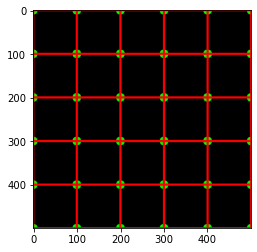

In [2]:
img = np.zeros((500, 500, 3), dtype = np.uint8)
for h in range(0, 501, 100):
    for w in range(0, 501, 100):
        cv2.circle(img, (w, h), 10, (0, 255, 0), -1)
        cv2.line(img, (0, h), (500, h), (255, 0, 0), 3)
        cv2.line(img, (w, 0), (w, 500), (255, 0, 0), 3)

plt.imshow(img);

## 1. Perspective transformation (OpenCV)

For `perspective transformation`, you need a `3x3` transformation matrix. 

Straight lines will remain straight even after the transformation. To find this transformation matrix, you need 4 points $A, B, C, D$ on the input image and corresponding points $A', B', C', D'$ on the output image. Among these 4 points, 3 of them should not be collinear. 

Then transformation matrix can be found by the function `cv2.getPerspectiveTransform`. 

Then apply `cv2.warpPerspective` with this 3x3 transformation matrix.



#### Initialize matrix-transformation.
For example, we want to create the matrix of perspective of the following 4 pair of points:

|    Input   |  Output    |
|:------------:|:------------:|
| $A$(56,65) | $A'$(0, 0) |
| $B$(369, 52) | $B'$(300, 0) |
| $C$(28, 387) | $C'$(0, 300) |
| $D$(389, 390) | $D'$(300, 300)

In [3]:
pts1 = np.float32([[56,65],[369,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)
M

array([[ 1.05167392e+00,  9.14499062e-02, -6.48379835e+01],
       [ 4.65712963e-02,  1.12129352e+00, -7.54920713e+01],
       [ 1.82130936e-04,  5.01486796e-04,  1.00000000e+00]])

Noting that, the `matrix transformation of perspective to itself` is the `eye-matrix`

In [4]:
print('M(pts1, pts1) = \n', np.round(cv2.getPerspectiveTransform(pts1, pts1), 4))
print('M(pts2, pts2) = \n', np.round(cv2.getPerspectiveTransform(pts2, pts2), 4))

M(pts1, pts1) = 
 [[ 1. -0.  0.]
 [-0.  1.  0.]
 [-0. -0.  1.]]
M(pts2, pts2) = 
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]]


Likewise, `M(pts1, pts2)` is inverse of `M(pts2, pts1)`, that meant

                        M(pts1, pts2) * M(pts2, pts1) = eye(n)
                       

In [5]:
print('M(pts1, pts2) * M(pts2, pts1) = \n', np.round(np.matmul(cv2.getPerspectiveTransform(pts2, pts1), 
                                                               cv2.getPerspectiveTransform(pts1, pts2)), 1))

print('M(pts2, pts1) * M(pts1, pts2) = \n', np.round(np.matmul(cv2.getPerspectiveTransform(pts1, pts2), 
                                                                cv2.getPerspectiveTransform(pts2, pts1)), 1))

M(pts1, pts2) * M(pts2, pts1) = 
 [[ 1.  0.  0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]
M(pts2, pts1) * M(pts1, pts2) = 
 [[ 1.  0.  0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


#### Example 1. Perspective with different output-dimension-region

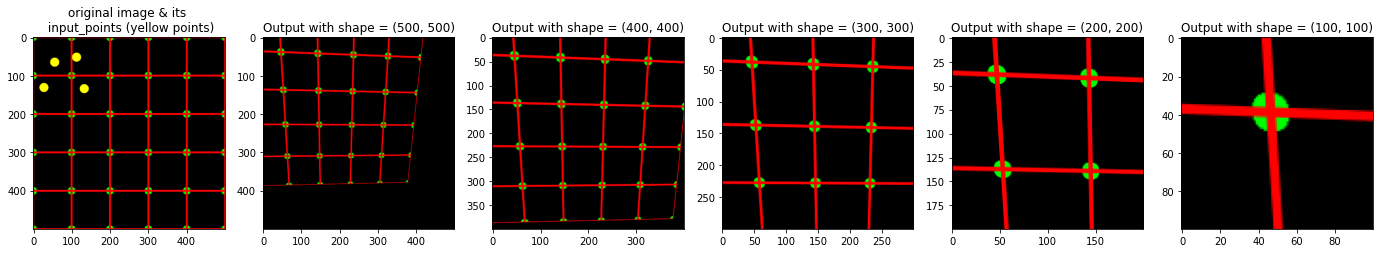

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (24, 6))
for k in range(6):
    dst = cv2.warpPerspective(img, M, ((6-k)*100, (6-k)*100))
    if k == 0:
        img_in = img.copy()
        for pts in np.uint8(pts1):
            rx, ry = pts
            cv2.circle(img_in, (rx, ry), 12, (255, 255, 0), -1)
        ax[k].set_title('original image & its \n input_points (yellow points)')
        ax[k].imshow(img_in)
    else:
        ax[k].imshow(dst)
        ax[k].set_title('Output with shape = (%s, %s)'%(600 - k*100, 600 - k*100))

#### Example 2. Keep the output_dimension = input_dimension while changing the input-point-coordinate

|    Input   |  Output_1    | Output_2 |
|:------------:|:------------:|:---------:|
| $A$(56,65) | $A_1$(0, 0) | $A_2$(50, 50)
| $B$(369, 52) | $B_1$(300, 0) | $B_2$(450, 50)
| $C$(28, 387) | $C_1$(0, 300) | $C_2$(50, 450)
| $D$(389, 390) | $D_1$(300, 300) | $D_2$(450, 400)

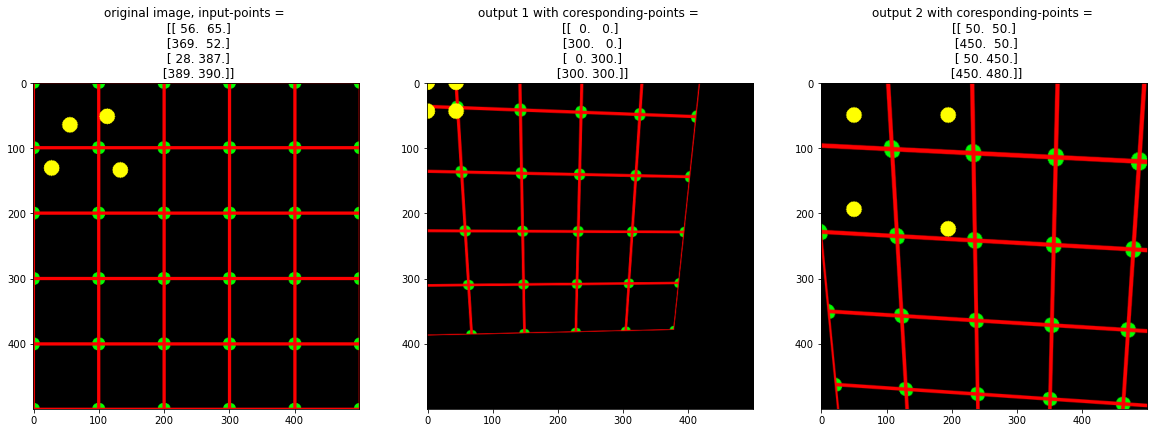

In [7]:
pts3 = np.float32([[50, 50],[450, 50], [50, 450], [450, 480]])

## create the lists of points, of titles
pts_list = [pts1, pts2, pts3]
titles = ['original image, input-points = \n ', 
          'output 1 with coresponding-points = \n', 'output 2 with coresponding-points = \n']

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))
for k in range(3):
    M = cv2.getPerspectiveTransform(pts1, pts_list[k])
    dst = cv2.warpPerspective(img, M, (500, 500))
    
    for pts in np.uint8(pts_list[k]):
        rx, ry = pts
        cv2.circle(dst, (rx, ry), 12, (255, 255, 0), -1)
    
    ax[k].set_title(titles[k] + str(pts_list[k]))
    ax[k].imshow(dst)

#### Application.

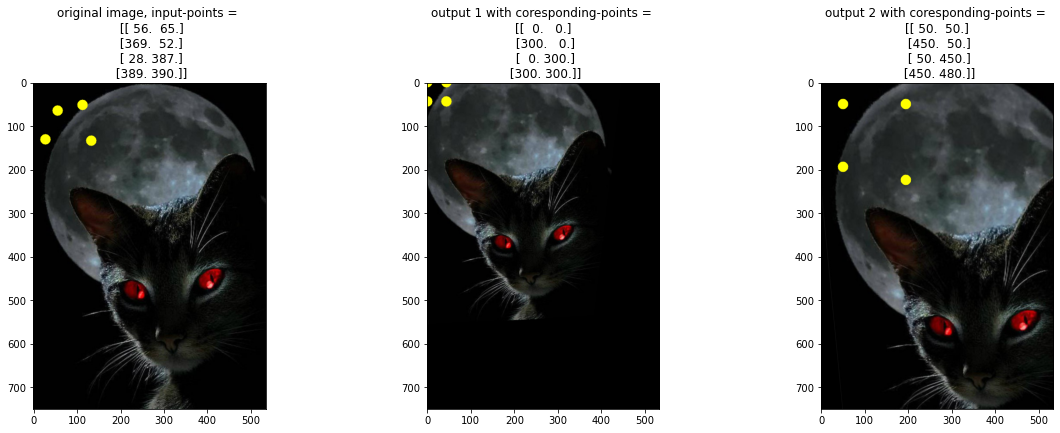

In [8]:
cat_img = si.imread('../input/nhabnn/screen_shoot_7.jpg')
h, w = cat_img.shape[:2]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))
for k in range(3):
    M = cv2.getPerspectiveTransform(pts1, pts_list[k])
    dst = cv2.warpPerspective(cat_img, M, (w, h))
    
    for pts in np.uint8(pts_list[k]):
        rx, ry = pts
        cv2.circle(dst, (rx, ry), 12, (255, 255, 0), -1)
    
    ax[k].set_title(titles[k] + str(pts_list[k]))
    ax[k].imshow(dst)

## 2. Homographies transformation (`skimage`)
Homographies are transformations of a Euclidean space that preserve the alignment of points. Specific cases of homographies correspond to the conservation of more properties, such as parallelism (affine transformation), shape (similar transformation) or distances (Euclidean transformation).

Homographies on a 2D Euclidean space (i.e., for 2D grayscale or multichannel images) are defined by a 3x3 matrix. All types of homographies can be defined by passing either the transformation matrix, or the parameters of the simpler transformations (rotation, scaling, …) which compose the full transformation.

The different types of homographies available in scikit-image are shown here, by increasing order of complexity (i.e. by reducing the number of constraints). While we focus here on the mathematical properties of transformations

### 2.1 Euclidean Transformation.

In [9]:
tform = st.EuclideanTransform( rotation=np.pi / 12.,
                               translation = (100, -20) 
                             )
tform.params

array([[  0.96592583,  -0.25881905, 100.        ],
       [  0.25881905,   0.96592583, -20.        ],
       [  0.        ,   0.        ,   1.        ]])

Now let’s apply this transformation to an image. Because we are trying to reconstruct the image after transformation, it is not useful to see where a coordinate from the input image ends up in the output, which is what the transform gives us. Instead, for every pixel (coordinate) in the output image, we want to figure out where in the input image it comes from. Therefore, we need to use the inverse of tform, rather than tform directly.

In [10]:
from skimage import img_as_float
img = img_as_float(img)

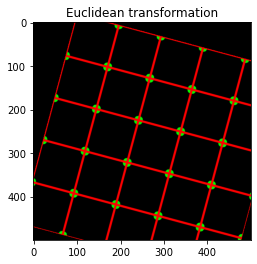

In [11]:
tf_img = st.warp(img, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('Euclidean transformation')

#### Example 3.

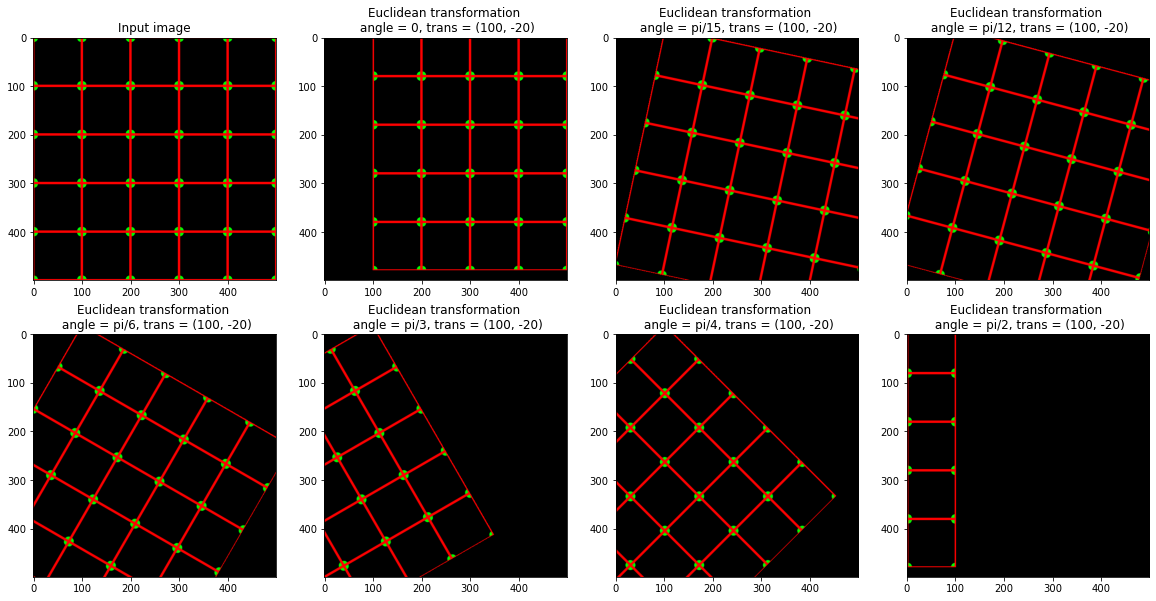

In [12]:
pi = np.pi
angles = [0, pi/15, pi/12, pi/6, pi/3, pi/4, pi/2]
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
ax = ax.ravel()

for k in range(8):
    if k == 0:
        ax[k].imshow(img); ax[k].set_title('Input image')
    else:
        tform = st.EuclideanTransform( rotation = angles[k-1],
                                       translation = (100, -20) 
                                     )
        tf_img = st.warp(img, tform.inverse)
        ax[k].imshow(tf_img)
        if k == 1:
            ax[k].set_title('Euclidean transformation \n angle = 0, trans = (100, -20)')
        else:
            ax[k].set_title('Euclidean transformation \n angle = pi/%s, trans = (100, -20)'%(int(pi/ angles[k-1])))

For a rotation around the center of the image, one can compose a translation to change the origin, a rotation, and finally the inverse of the first translation.

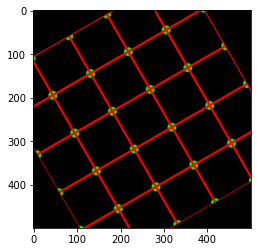

In [13]:
rotation = st.EuclideanTransform(rotation=np.pi/3)
shift = st.EuclideanTransform(translation=-np.array(img.shape[:2]) / 2)

# Compose transforms by multiplying their matrices
matrix = np.linalg.inv(shift.params) @ rotation.params @ shift.params
tform = st.EuclideanTransform(matrix)
tf_img = st.warp(img, tform.inverse)
fig, ax = plt.subplots()
_ = ax.imshow(tf_img)

#### Example 4.

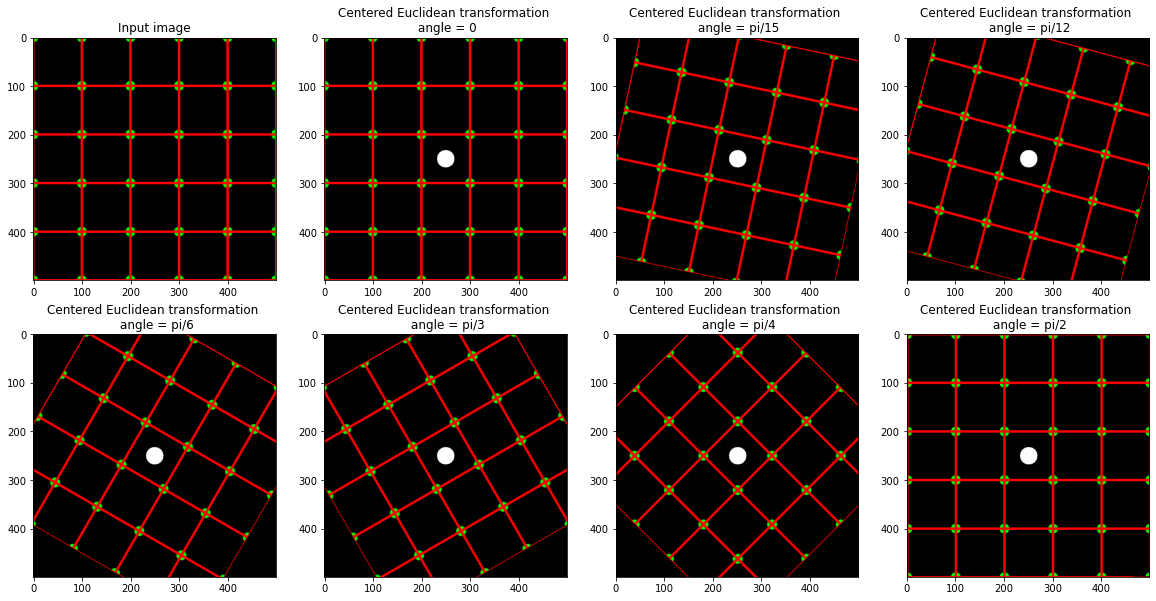

In [14]:
pi = np.pi
angles = [0, pi/15, pi/12, pi/6, pi/3, pi/4, pi/2]
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
ax = ax.ravel()

for k in range(8):
    if k == 0:
        ax[k].imshow(img); ax[k].set_title('Input image')
    else:
        rotation = st.EuclideanTransform( rotation = angles[k-1])
        shift = st.EuclideanTransform(translation=-np.array(img.shape[:2]) / 2)
        matrix = np.linalg.inv(shift.params) @ rotation.params @ shift.params
        tform = st.EuclideanTransform(matrix)
        tf_img = st.warp(img, tform.inverse)
        cv2.circle(tf_img, (250, 250), 18, (255, 255, 255), -1)
        ax[k].imshow(tf_img)
        if k == 1:
            ax[k].set_title('Centered Euclidean transformation \n angle = 0')
        else:
            ax[k].set_title('Centered Euclidean transformation \n angle = pi/%s'%(int(pi/ angles[k-1])))

#### Application

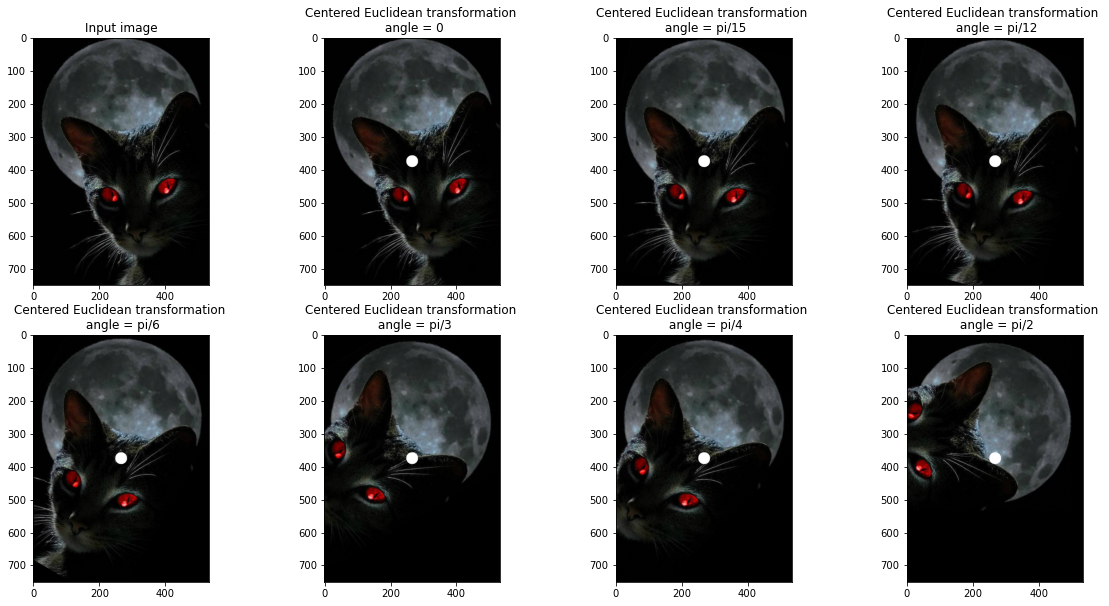

In [15]:
pi = np.pi
angles = [0, pi/15, pi/12, pi/6, pi/3, pi/4, pi/2]
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
ax = ax.ravel()

for k in range(8):
    if k == 0:
        ax[k].imshow(cat_img); ax[k].set_title('Input image')
    else:
        rotation = st.EuclideanTransform( rotation = angles[k-1])
        shift = st.EuclideanTransform(translation=-np.array(img.shape[:2]) / 2)
        matrix = np.linalg.inv(shift.params) @ rotation.params @ shift.params
        tform = st.EuclideanTransform(matrix)
        tf_img = st.warp(cat_img, tform.inverse)
        cv2.circle(tf_img, (w//2, h//2), 18, (255, 255, 255), -1)
        ax[k].imshow(tf_img)
        if k == 1:
            ax[k].set_title('Centered Euclidean transformation \n angle = 0')
        else:
            ax[k].set_title('Centered Euclidean transformation \n angle = pi/%s'%(int(pi/ angles[k-1])))

### 2.2. Similarity transformation
A similarity transformation preserves the shape of objects. It combines scaling, translation and rotation.



In [16]:
tform = st.SimilarityTransform(
                                scale=0.5,
                                rotation=np.pi/12,
                                translation=(100, 50))
tform.params

array([[  0.48296291,  -0.12940952, 100.        ],
       [  0.12940952,   0.48296291,  50.        ],
       [  0.        ,   0.        ,   1.        ]])

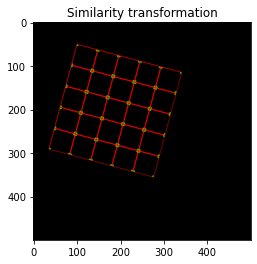

In [17]:
tf_img = st.warp(img, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('Similarity transformation')

#### Application

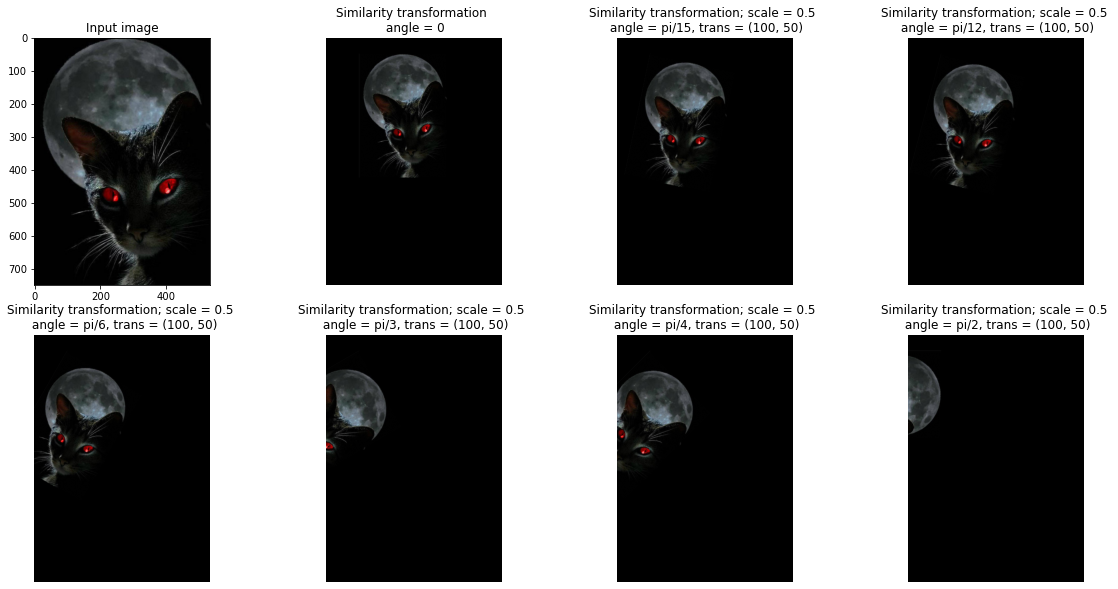

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
ax = ax.ravel()

for k in range(8):
    if k == 0:
        ax[k].imshow(cat_img); ax[k].set_title('Input image')
    else:
        tform = st.SimilarityTransform( scale = 0.5,
                                        rotation = angles[k - 1],
                                        translation = (100, 50))
        tf_img = st.warp(cat_img, tform.inverse)
        ax[k].imshow(tf_img)
        ax[k].set_axis_off()
        if k == 1:
            ax[k].set_title('Similarity transformation \n angle = 0')
            
        else:
            ax[k].set_title('Similarity transformation; scale = 0.5 \n angle = pi/%s, trans = (%s, %s)'
                            %(int(pi/ angles[k-1]), 100, 50))

### 2.3. Affine transformation
An affine transformation preserves lines (hence the alignment of objects), as well as parallelism between lines. It can be decomposed into a similarity transform and a shear transformation.



In [19]:
tform = st.AffineTransform(
        shear=np.pi/6,
        )
tform.params

array([[ 1.       , -0.5      ,  0.       ],
       [ 0.       ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  1.       ]])

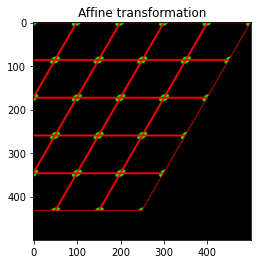

In [20]:
tf_img = st.warp(img, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('Affine transformation')

### 2.4. Projective transformation

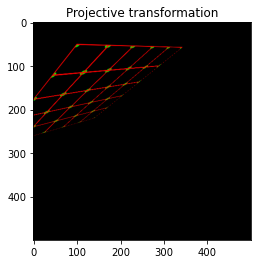

In [21]:
matrix = np.array([[1, -0.5, 100],
                   [0.1, 0.9, 50],
                   [0.0015, 0.0015, 1]])
tform = st.ProjectiveTransform(matrix=matrix)
tf_img = st.warp(img, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
ax.set_title('Projective transformation')

plt.show()